In [5]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

def rotateToEigenH(O,H): #rotate an operator $O$ in the basis of the eigenstates of the hamiltonian $H$
    RH=np.array(H.eigenstates()[1][0])
    for V in H.eigenstates()[1][1:]:
        RH=np.column_stack((RH,np.array(V)))
    RH=Qobj(RH, dims=H.dims)
    return RH.dag()*O*RH

def rate(nu,beta,E):
    return nu*E/(np.exp(beta*E)-1)

def ratebar(nu,beta,E):
    return nu*E*np.exp(beta*E)/(np.exp(beta*E)-1)

def jumpOp(params,H):
    DIM=H.dims
    nuC=params[0] #Coupling to cold bath
    nuH=params[1] #Coupling to hot bath
    betaC=params[2] #Inverse temperature of the cold bath
    betaH=params[3] #Inverse temperature of the hot bath
    E=H.eigenenergies()
    eigH=[]
    for V in H.eigenstates()[1]:
        eigH.append(V)
    #These definitions are a bit hard to read but it was very easy to code. Essentially I'm rewriting the above operators directly as a function of the hamiltonian
#eigenstates, doing explicitely the outer product of the corresponding ket and bra.
#Since the dimension of the final quantum object is not correct, I cast it to a numpy array and then back to Qobj with the correct dims.
#The pedex c and h stands for cold and hot, while m is for lower transition (minus) and p upper transition (plus).
    Lcm=Qobj(eigH[2]*eigH[3].dag()-eigH[0]*eigH[1].dag())/np.sqrt(2)
    Lcp=Qobj(eigH[1]*eigH[3].dag()+eigH[0]*eigH[2].dag())/np.sqrt(2)
    Lhm=Qobj(eigH[2]*eigH[3].dag()+eigH[0]*eigH[1].dag())/np.sqrt(2)
    Lhp=Qobj(-eigH[1]*eigH[3].dag()+eigH[0]*eigH[2].dag())/np.sqrt(2)
    c_ops = []

    gamma = rate(nuC,betaC,E[1])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lcm.dag())

    gamma = rate(nuH,betaH,E[1])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lhm.dag())

    gamma = rate(nuC,betaC,E[2])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lcp.dag())

    gamma = rate(nuH,betaH,E[2])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lhp.dag())

    gamma = ratebar(nuC,betaC,E[1])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lcm)

    gamma = ratebar(nuH,betaH,E[1])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lhm)

    gamma = ratebar(nuC,betaC,E[2])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lcp)

    gamma = ratebar(nuH,betaH,E[2])
    if gamma > 0.0:
        c_ops.append(np.sqrt(gamma) * Lhp)
        
    return c_ops
    
def Work(rho,U,H):
    return (H*U*rho*U.dag()-H*rho).tr()


#this is wrong#
def WorkVar(rho,U,H):
    eigH=[]
    for V in H.eigenstates()[1]:
        eigH.append(V)
    N=len(eigH)
    W2=0
    for n in range(N):
        for m in range(N):
            W2+=eigH[n].dag()*rho*eigH[n]*abs(eigH[m].dag()*U*eigH[n])**2*(eigH[m].dag()*H*U*rho*U.dag()*eigH[m]-eigH[n].dag()*H*rho*eigH[n])**2
    return float(np.real(W2-Work(rho,U,H)**2))

# Two qubits hamiltonian

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
We consider a system $S$ composed of two qubits. 

The Hamiltonian of $S$ is 

\begin{equation}
H=H_0+H_{int} 
\,
,
\end{equation}
with
\begin{align}
	{H_0}&=\Omega_c \ket{1}\bra{1}\otimes\mathbb{I}_2 + \Omega_h \mathbb{I}_2 \otimes \ket{1}\bra{1}
	\end{align}

containing the local Hamiltonians of each subsystem and a coupling flip-flop term 

\begin{equation}
	{H}_{int}=g(\ket{01}\bra{10} + \ket{10}\bra{01})~.
\end{equation}

We consider for simplicity the resonant case $\Omega_c=\Omega_h\equiv\Omega$ that makes the eigenvalues of $H$ ($0$, $\Omega- g$, $\Omega+g$, $2\Omega$) with eigenvectors
\begin{align}\nonumber
	\ket{\varphi_0}&=\ket{0,0}\\
	\nonumber
	\ket{\varphi_{\Omega\pm g}}&=\frac{\ket{0,1}\pm\ket{1,0}}{\sqrt{2}}\\
	%\nonumber
	\ket{\varphi_{2\Omega}}&=\ket{1,1}\,.
	\label{eigenvectors}
	\end{align}

In [6]:
Omega=1 #Energy spacing of the qubits
g=0.5 #Qubits interaction strength
nuC=0.004 #Coupling to cold bath
nuH=0.004 #Coupling to hot bath
betaC=2 #Inverse temperature of the cold bath
betaH=1 #Inverse temperature of the hot bath


Proj1=basis(2,1).proj() #Projector operator |1><1|
Flip=Qobj([[0, 0, 0, 0],[0, 0, 1, 0],[0, 1, 0, 0], [0, 0, 0, 0]], dims=[[2, 2], [2, 2]]) #Flip-Flop operator |01><10|+|10><01|
H_0=Omega*(tensor(Proj1,qeye(2))+tensor(qeye(2),Proj1))
H_int=g*Flip
H=H_0+H_int
U=Qobj([[0,0,0,1],[0,1,0,0],[0,0,-1,0],[1,0,0,0]],dims=[[2,2],[2,2]])

print('**The Hamiltonian of the system is ** \n')
print(H)

E=H.eigenenergies()
print('\n** The energy levels are **\n')
print(E)
eigH=[]

for V in H.eigenstates()[1]:
    eigH.append(V)
    
print('\n ** The corresponding eigenstates are **\n')
print(eigH)

**The Hamiltonian of the system is ** 

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  1.  0.5 0. ]
 [0.  0.5 1.  0. ]
 [0.  0.  0.  2. ]]

** The energy levels are **

[0.  0.5 1.5 2. ]

 ** The corresponding eigenstates are **

[Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.70710678]
 [-0.70710678]
 [ 0.        ]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]]]


# Dynamics

The system is in {weak} coupling with two {Markovian} thermal baths $B_c$ and $B_h$ at temperatures $1/\beta_c$ (colder) and $1/\beta_h$ (hotter), respectively. 

We also assume the thermal baths to be bosonic interacting with the system by a flip-flop interaction Hamiltonian. 

In this framework, the dynamics of $S$ is described by the  Gorini–Kossakowski–Sudarshan–Lindblad equation (GKSL).

Furthermore, we consider Ohmic spectral density and, more importantly, strong internal coupling with the aim of generating entanglement.
According to this setup, only transitions with energies $\Omega\pm g$ can be induced by the system-bath coupling considered here, with 

corresponding jump operators being

\begin{align}
	{L}_{c,\Omega-g}&=\frac{1}{\sqrt{2}}\ket{\varphi_{\Omega+g}}\bra{\varphi_{2\Omega}}-\frac{1}{\sqrt{2}}\ket{\varphi_0}\bra{\varphi_{\Omega-g}}\\
	{L}_{c,\Omega+g}&=\frac{1}{\sqrt{2}}\ket{\varphi_{\Omega-g}}\bra{\varphi_{2\Omega}}+\frac{1}{\sqrt{2}}\ket{\varphi_0}\bra{\varphi_{\Omega+g}}\\
	{L}_{h,\Omega-g}&=\frac{1}{\sqrt{2}}\ket{\varphi_{\Omega+g}}\bra{\varphi_{2\Omega}}+\frac{1}{\sqrt{2}}\ket{\varphi_0}\bra{\varphi_{\Omega-g}}\\
	{L}_{h,\Omega+g}&=-\frac{1}{\sqrt{2}}\ket{\varphi_{\Omega-g}}\bra{\varphi_{2\Omega}}+\frac{1}{\sqrt{2}}\ket{\varphi_0}\bra{\varphi_{\Omega+g}}\,.
	\end{align}

In [8]:
Lcm=Qobj(eigH[2]*eigH[3].dag()-eigH[0]*eigH[1].dag())/np.sqrt(2)
Lcp=Qobj(eigH[1]*eigH[3].dag()+eigH[0]*eigH[2].dag())/np.sqrt(2)
Lhm=Qobj(eigH[2]*eigH[3].dag()+eigH[0]*eigH[1].dag())/np.sqrt(2)
Lhp=Qobj(-eigH[1]*eigH[3].dag()+eigH[0]*eigH[2].dag())/np.sqrt(2)

In this regime the global master equation yields an accurate description of the system state.

\begin{multline}
	\dot{\rho}(t) = -i\left[ {H}_S, {\rho}(t)\right] +  \sum_{\alpha=c,h} \sum_{\epsilon=\Omega\pm g} \Big(\Gamma_{\alpha,\epsilon} \mathcal{D}[{L}_{\alpha,\epsilon}^\dagger]{\rho}(t) + \overline{\Gamma}_{\alpha,\epsilon} \mathcal{D}[{L}_{\alpha,\epsilon}]{\rho}(t)\Big)
	\end{multline}

In [9]:
c_ops = []

print('** The rates are: **\n')

gamma = rate(nuC,betaC,E[1])
print(gamma)
if gamma > 0.0:
    c_ops.append(gamma * Lcm.dag())

gamma = rate(nuH,betaH,E[1])
print(gamma)

if gamma > 0.0:
    c_ops.append(gamma * Lhm.dag())
    
gamma = rate(nuC,betaC,E[2])
print(gamma)

if gamma > 0.0:
    c_ops.append(gamma * Lcp.dag())
    
gamma = rate(nuH,betaH,E[2])
print(gamma)

if gamma > 0.0:
    c_ops.append(gamma * Lhp.dag())
    
gamma = ratebar(nuC,betaC,E[1])
print(gamma)

if gamma > 0.0:
    c_ops.append(gamma * Lcm)

gamma = ratebar(nuH,betaH,E[1])
print(gamma)

if gamma > 0.0:
    c_ops.append(gamma * Lhm)
    
gamma = ratebar(nuC,betaC,E[2])
print(gamma)

if gamma > 0.0:
    c_ops.append(gamma * Lcp)
    
gamma = ratebar(nuH,betaH,E[2])
print(gamma)

if gamma > 0.0:
    c_ops.append(gamma * Lhp)
    

print('\n ** The jump operators are: **\n')

print(c_ops)

print('\n ** The jump operators in the Hamiltonian eigenbasis are: **\n')

print(rotateToEigenH(c_ops,H))

** The rates are: **

0.001163953413738653
0.0030829881650735963
0.00031437417894753574
0.0017233015007332097
0.003163953413738653
0.005082988165073596
0.006314374178947536
0.007723301500733209

 ** The jump operators are: **

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.          0.          0.          0.        ]
 [-0.00058198  0.          0.          0.        ]
 [ 0.00058198  0.          0.          0.        ]
 [ 0.          0.00058198  0.00058198  0.        ]], Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.00154149  0.          0.          0.        ]
 [-0.00154149  0.          0.          0.        ]
 [ 0.          0.00154149  0.00154149  0.        ]], Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.          0.          0.          0.        ]
 [ 0.00015719  0. 

In [10]:
rho0=ket2dm((eigH[1]+eigH[2])/np.sqrt(2))
tlist = np.linspace(0, 2000, 100)

output = mesolve(H, rho0, tlist, c_ops, [])

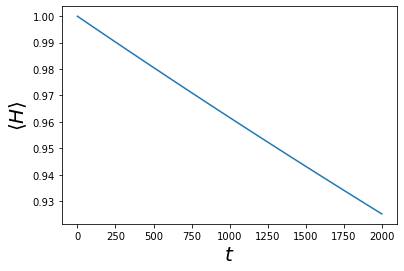

In [11]:
fig, axes = plt.subplots(1,1)

axes.plot(tlist, expect(H, output.states))

axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r'$\left<H\right>$', fontsize=20);

The NESS, the stationary state of equation, is diagonal in the Hamiltonian basis,


\begin{eqnarray}
\label{ness}
    {\rho}_{ness} =\rho_0 \ket{\varphi_0}\bra{\varphi_0}+
    \rho_- \ket{\varphi_{\Omega-g}}\bra{\varphi_{\Omega-g}}+\nonumber
    \rho_+\ket{\varphi_{\Omega+g}}\bra{\varphi_{\Omega+g}}+\nonumber
    \rho_{2\Omega} \ket{\varphi_{2 \Omega}}\bra{\varphi_{2 \Omega}}\nonumber\,,
\end{eqnarray}

with coefficients

\begin{eqnarray}
     \rho_0&=&a (\overline{\Gamma}_{c,\Omega-g}+\overline{\Gamma}_{h,\Omega-g})(\overline{\Gamma}_{c,\Omega+g}+\overline{\Gamma}_{h,\Omega+g}) \,,\\
    %
    \rho_-&=&a (\Gamma_{c,\Omega-g}+\Gamma_{h,\Omega-g})(\overline{\Gamma}_{c,\Omega+g}+\overline{\Gamma}_{h,\Omega+g})\,,\\
    %
    \rho_+&=&a (\overline{\Gamma}_{c,\Omega-g}+\overline{\Gamma}_{h,\Omega-g})(\Gamma_{c,\Omega+g}+\Gamma_{h,\Omega+g})\,,\\
    %
    \rho_{2 \Omega}&=&a (\Gamma_{c,\Omega-g}+\Gamma_{h,\Omega-g})(\Gamma_{c,\Omega+g}+\Gamma_{h,\Omega+g})\,,
    \end{eqnarray}
    
where the common proportionality  coefficient $a$ is the positive normalization quantity ensuring $Tr({\rho}_{ness}) = 1$.

In [12]:
params=[nuC,nuH,betaC,betaH] 
rhoSS=steadystate(H,jumpOp(params,H))
print('The steady state of the above dynamics is \n')
rhoSS

The steady state of the above dynamics is 



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.57640828+0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.19025201+0.00000000e+00j
  -0.10658195+2.06704562e-19j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j -0.10658195-2.06704562e-19j
   0.19025201+0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.04308771+0.00000000e+00j]]

In [13]:
rho0=(ratebar(nuC,betaC,E[1])+ratebar(nuH,betaH,E[1]))*(ratebar(nuC,betaC,E[2])+ratebar(nuH,betaH,E[2]))
rhom=(rate(nuC,betaC,E[1])+rate(nuH,betaH,E[1]))*(ratebar(nuC,betaC,E[2])+ratebar(nuH,betaH,E[2]))
rhop=(rate(nuC,betaC,E[2])+rate(nuH,betaH,E[2]))*(ratebar(nuC,betaC,E[1])+ratebar(nuH,betaH,E[1]))
rho2=(rate(nuC,betaC,E[1])+rate(nuH,betaH,E[1]))*(rate(nuC,betaC,E[2])+rate(nuH,betaH,E[2]))

rss=np.diag([rho0,rhom,rhop,rho2])
rss=rss/np.trace(rss)
print(rotateToEigenH(rss,H))

[[0.57640828+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.19025201+0.j 0.10658195+0.j 0.        +0.j]
 [0.        +0.j 0.10658195+0.j 0.19025201+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.04308771+0.j]]


# Thermodynamic Cycle

Here we compute the signal-to-noise ratio of work extraction from the system after the application of the unitary.

In [24]:
NNN=20
ggg=np.linspace(0.5,0.9,NNN)
W=np.zeros(NNN)
for i in range(NNN):
    H=H_0+ggg[i]*Flip
    W[i]=Work(rhoSS,U,H)


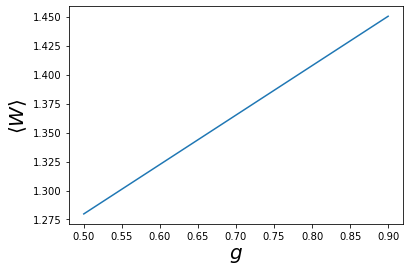

In [25]:
fig, axes = plt.subplots(1,1)

axes.plot(ggg, W)

axes.set_xlabel(r'$g$', fontsize=20)
axes.set_ylabel(r'$\left<W\right>$', fontsize=20);

In [26]:
nuC=0.004 #Coupling to cold bath
nuH=0.004 #Coupling to hot bath
betaC=2 #Inverse temperature of the cold bath
betaH=1 #Inverse temperature of the hot bath
g=0.5

H_0=Omega*(tensor(Proj1,qeye(2))+tensor(qeye(2),Proj1))
H_int=g*Flip
H=H_0+H_int

params=[nuC,nuH,betaC,betaH] 
rhoSS=steadystate(H,jumpOp(params,H))
print('The steady state of the above dynamics in the energy eigenbasis is \n')
rotateToEigenH(rhoSS,H)

The steady state of the above dynamics in the energy eigenbasis is 



Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.57640828 0.         0.         0.        ]
 [0.         0.29683395 0.         0.        ]
 [0.         0.         0.08367006 0.        ]
 [0.         0.         0.         0.04308771]]